In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

In [16]:

class Dataset(Dataset):
    def __init__(self, images_dir, masks_dir, imasks_dir, features_dir, transform=None, feature_dim=128):
        self.samples = []
        self.transform = transform
        self.feature_dim = min(feature_dim, 128)  # Ensure feature dimension is <= 128
        
        # If transform is not provided, use a default one
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
        
        # Create separate transform for masks if needed
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

        self.imask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        
        # Loop over each class (subdirectory)
        print(os.listdir(images_dir))
        for class_name in os.listdir(images_dir):
            class_path = os.path.join(images_dir, class_name)
            if not os.path.isdir(class_path):
                continue
                
            img_dir = os.path.join(class_path, 'occluded')
            mask_dir = os.path.join(class_path, 'masks')
            imask_dir = os.path.join(class_path, 'imasks')
            
            # Check if directories exist
            if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
                print(f"Warning: Missing directories for class {class_name}")
                continue
            # Check if directories exist
            if not os.path.exists(img_dir) or not os.path.exists(imask_dir):
                print(f"Warning: Missing directories for class {class_name}")
                continue
            # Check feature file
            feat_path = os.path.join(features_dir, class_name + '.npy')
            if not os.path.exists(feat_path):
                print(f"Warning: Missing feature file for class {class_name}")
                continue
                
            for img_name in os.listdir(img_dir):
                if img_name.endswith(('.jpg', '.png')):
                    base_name = os.path.splitext(img_name)[0]  # e.g., "happy_001"
                    mask_path = os.path.join(mask_dir, base_name + '_mask.png')
                    imask_path = os.path.join(imask_dir, base_name + '_imask.png')
                    
                    # Verify that the corresponding mask exists
                    if not os.path.exists(mask_path):
                        print(f"Warning: Missing mask for {img_name} in class {class_name}")
                        continue

                    if not os.path.exists(imask_path):
                        print(f"Warning: Missing mask for {img_name} in class {class_name}")
                        continue
            
                    self.samples.append({
                        'class': class_name,
                        'img_path': os.path.join(img_dir, img_name),
                        'mask_path': mask_path,
                        'imask_path': imask_path,
                        'feat_path': feat_path,
                        'img_name': img_name
                    })
        
        print(f"Dataset initialized with {len(self.samples)} samples")
                    
    def __len__(self):
        return len(self.samples)
    
    def _resize_feature(self, feature, target_dim):
        """Resize feature vector to target dimension"""
        feature_len = len(feature)
        
        if feature_len == target_dim:
            return feature
        elif feature_len > target_dim:
            # Truncate to target dimension
            return feature[:target_dim]
        else:
            # Pad with zeros to target dimension
            padded = np.zeros(target_dim)
            padded[:feature_len] = feature
            return padded
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        try:
            # Load image and mask
            image = Image.open(sample['img_path']).convert('RGB')
            mask = Image.open(sample['mask_path']).convert('L')
            imask = Image.open(sample['imask_path']).convert('RGB')
            
            
            # Apply transformations
            image = self.transform(image)
            mask = self.mask_transform(mask)
            imask = self.imask_transform(imask)
            
            
            # Binarize mask (0 or 1)
            mask = (mask > 0.5).float()
            
            # Load feature vector and resize to consistent dimension
            feature = np.load(sample['feat_path'])
            
            # If feature is multi-dimensional, flatten first
            if feature.ndim > 1:
                feature = feature.flatten()
                
            # Resize feature to target dimension
            feature = self._resize_feature(feature, self.feature_dim)
            feature = torch.tensor(feature, dtype=torch.float32)
            
            return {
                'occluded_image': image,
                'mask': mask,
                'imask' : imask, 
                'feature': feature,
                'image_name': sample['img_name'],
                'class_name': sample['class']
            }
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return a default item in case of errors
            return {
                'occluded_image': torch.zeros(3, 256, 256),
                'mask': torch.zeros(1, 256, 256),
                'imask': torch.zeros(3, 256, 256),
                'feature': torch.zeros(self.feature_dim),
                'image_name': 'error_image.jpg',
                'class_name': 'error'
            }


['2820', '3227', '3699', '3745', '3782', '4887', '6568', '8968', '9152', '9256']
Dataset initialized with 5094 samples
Batch 0
Images shape: torch.Size([8, 3, 256, 256])
Masks shape: torch.Size([8, 1, 256, 256])
Features shape: torch.Size([8, 128])
Classes: ['6568', '3782', '3699', '8968', '9152', '4887', '3745', '9256']


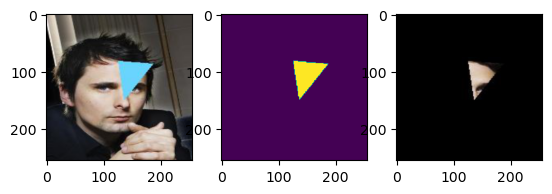

In [17]:
images_dir='/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x'
masks_dir='/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x'
imasks_dir='/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x'
features_dir='/home/jt/GAN/face_features'

# Create dataset with feature dimension of 64 (or any value <= 128)
dataset = Dataset(
    images_dir=images_dir, 
    masks_dir=masks_dir, 
    imasks_dir = imasks_dir,
    features_dir=features_dir,
    feature_dim=128  # Choose your desired dimension
)

# Create DataLoader with standard collate function (now safe)
loader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2
)

# Test the dataloader
for i, batch in enumerate(loader):
    print(f"Batch {i}")
    print(f"Images shape: {batch['occluded_image'].shape}")
    print(f"Masks shape: {batch['mask'].shape}")
    print(f"Features shape: {batch['feature'].shape}")  # Should be [batch_size, feature_dim]
    print(f"Classes: {batch['class_name']}")
    plt.subplot(1, 3, 1)
    plt.imshow(batch['occluded_image'][0].permute(1, 2, 0))

    plt.subplot(1, 3, 2)
    plt.imshow(batch['mask'][0].permute(1, 2, 0))
    plt.subplot(1, 3, 3)
    plt.imshow(batch['imask'][0].permute(1, 2, 0))
    
    # Break after first batch for testing
    if i == 0:
        break

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key   = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)    # B x HW x C'
        key = self.key(x).view(B, -1, H * W)                         # B x C' x HW
        attention = torch.bmm(query, key)                           # B x HW x HW
        attention = F.softmax(attention, dim=-1)

        value = self.value(x).view(B, -1, H * W)                    # B x C x HW
        out = torch.bmm(value, attention.permute(0, 2, 1))          # B x C x HW
        out = out.view(B, C, H, W)

        return self.gamma * out + x

class AttentionGenerator(nn.Module):
    def __init__(self, feature_dim=128):
        super(AttentionGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),  # 3 channels + mask
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SelfAttention(128),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SelfAttention(256),
        )

        self.feature_proj = nn.Sequential(
            nn.Linear(feature_dim, 256 * 32 * 32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, image, mask, feature):
        x = torch.cat([image, mask], dim=1)  # Shape: (B, 4, 256, 256)
        enc = self.encoder(x)  # Shape: (B, 256, 32, 32)
        feat = self.feature_proj(feature).view(-1, 256, 32, 32)
        combined = torch.cat([enc, feat], dim=1)
        out = self.decoder(combined)
        return out


In [19]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),  # 3 channels + mask
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, image, mask):
        # 4-channel input
        x = torch.cat([image, mask], dim=1)
        return self.model(x)


In [21]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def visualize_results(generator, batch, epoch, num_images=8):
    generator.eval()
    
    with torch.no_grad():
        occluded = batch['occluded_image'].cuda()
        mask = batch['mask'].cuda()
        feature = batch['feature'].cuda()
        output = generator(occluded, mask, feature)

    # Limit to num_images for cleaner display
    occluded = occluded[:num_images]
    output = output[:num_images]
    mask = mask[:num_images]

    # Prepare blended output
    blended = output * mask + occluded * (1 - mask)

    # Convert tensors to a grid (NCHW -> grid image)
    occluded_grid = vutils.make_grid(occluded, nrow=num_images, normalize=True, scale_each=True)
    blended_grid = vutils.make_grid(blended, nrow=num_images, normalize=True, scale_each=True)
    #mask_grid = vutils.make_grid(mask.repeat(1, 3, 1, 1), nrow=num_images, normalize=True, scale_each=True)

    # Plot all three rows: Occluded, Reconstructed, Mask
    fig, axes = plt.subplots(3, 1, figsize=(num_images * 2, 6))
    titles = ['Occluded Images', 'Reconstructed (Blended)', 'Masks']

    for i, grid in enumerate([occluded_grid, blended_grid]):
        axes[i].imshow(grid.permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.suptitle(f"Epoch {epoch+1} Results")
    plt.tight_layout()
    plt.show()


In [ ]:
class StableContextualAttention(nn.Module):
    def __init__(self, in_channels, rate=2):
        super(StableContextualAttention, self).__init__()
        self.rate = rate
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
       
    def forward(self, x, mask):
        # Simplified implementation to avoid numerical instability
        B, C, H, W = x.shape
       
        # Split into known and unknown regions
        x_known = x * (1 - mask)
       
        # Simple attention mechanism
        # Apply convolution to get query and key features
        query = F.conv2d(x * mask, self.conv.weight, self.conv.bias, padding=0)
        key = F.conv2d(x_known, self.conv.weight, self.conv.bias, padding=0)
       
        # Normalize features for stable cosine similarity
        query_norm = F.normalize(query.view(B, C, -1), dim=1)
        key_norm = F.normalize(key.view(B, C, -1), dim=1)
       
        # Calculate attention with numerical stability
        attention = torch.bmm(query_norm.permute(0, 2, 1), key_norm)
        attention = F.softmax(attention / 0.1, dim=-1)  # Temperature scaling for stability
       
        # Weighted sum of values
        value = x_known.view(B, C, -1)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
       
        # Combine with original features
        return x_known + out * mask

In [ ]:
def stable_edge_aware_loss(generated, real, mask, eps=1e-8):
    # Use pre-defined Sobel kernels
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
                         dtype=torch.float32).view(1, 1, 3, 3).cuda()
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
                         dtype=torch.float32).view(1, 1, 3, 3).cuda()
   
    # Apply to each channel with gradient clipping
    def get_edges(image):
        edges = []
        for c in range(image.shape[1]):
            channel = image[:, c:c+1]
            grad_x = F.conv2d(channel, sobel_x, padding=1)
            grad_y = F.conv2d(channel, sobel_y, padding=1)
            # Add epsilon for numerical stability
            edge = torch.sqrt(torch.clamp(grad_x**2 + grad_y**2, min=eps))
            edges.append(edge)
        return torch.cat(edges, dim=1)
   
    # Get edges with gradient clipping
    gen_edge = torch.clamp(get_edges(generated), max=10.0)
    real_edge = torch.clamp(get_edges(real), max=10.0)
   
    # Calculate loss only in mask region with gradient clipping
    edge_loss = F.l1_loss(gen_edge * mask, real_edge * mask)
    return torch.clamp(edge_loss, max=10.0)  # Prevent extreme values

In [ ]:
class StableGatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(StableGatedConv2d, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
       
    def forward(self, x):
        feature = self.conv2d(x)
        # Use tanh instead of sigmoid for better gradient stability
        mask = torch.tanh(self.mask_conv2d(x)) * 0.5 + 0.5
        return feature * mask

In [ ]:
class StableGenerator(nn.Module):
    def __init__(self, feature_dim=128):
        super(StableGenerator, self).__init__()
       
        # Encoder with stable gated convolutions
        self.encoder = nn.Sequential(
            StableGatedConv2d(4, 64, 4, 2, 1),  # 3 channels + mask
            nn.LeakyReLU(0.2, inplace=True),
            StableGatedConv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),  # Use InstanceNorm instead of BatchNorm for stability
            nn.LeakyReLU(0.2, inplace=True),
            StableGatedConv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
       
        # Feature projection with weight normalization
        self.feature_proj = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(feature_dim, 256 * 32 * 32)),
            nn.LeakyReLU(0.2, inplace=True)
        )
       
        # Simplified attention module
        self.attention = StableContextualAttention(512)
       
        # Decoder with skip connections for stability
        self.decoder1 = nn.Sequential(
            StableGatedConv2d(512, 256, 3, 1, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
       
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
       
        self.decoder3 = nn.Sequential(
            StableGatedConv2d(128, 64, 3, 1, 1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
       
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )
       
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()  # Constrain output to [-1, 1]
        )

    def forward(self, image, mask, feature):
        # Input concatenation
        x = torch.cat([image, mask], dim=1)
       
        # Encoding
        enc = self.encoder(x)
       
        # Feature projection with clamping for stability
        feat = self.feature_proj(feature).view(-1, 256, 32, 32)
        feat = torch.clamp(feat, -10, 10)  # Prevent extreme values
       
        # Combine encoder output and feature projection
        combined = torch.cat([enc, feat], dim=1)
       
        # Apply attention with downsampled mask for stability
        mask_downsampled = F.interpolate(mask, size=combined.shape[2:], mode='nearest')
        attended = self.attention(combined, mask_downsampled)
       
        # Decode with gradient clamping between stages
        x = self.decoder1(attended)
        x = torch.clamp(x, -10, 10)
       
        x = self.decoder2(x)
        x = torch.clamp(x, -10, 10)
       
        x = self.decoder3(x)
        x = torch.clamp(x, -10, 10)
       
        x = self.decoder4(x)
        x = torch.clamp(x, -10, 10)
       
        x = self.decoder5(x)
       
        # Apply mask for final output
        return image * (1 - mask) + x * mask

In [ ]:

# Create models with gradient clipping and stable normalization
generator = StableGenerator(feature_dim=128).cuda()
discriminator = PatchDiscriminator().cuda()

# Initialize with smaller learning rate
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Loss functions
bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

# Gradient clipping parameters
max_grad_norm = 1.0


Epoch 1/50 -- G_loss: 2.1749, D_loss: 0.6514


Epoch 2/50 -- G_loss: 2.1548, D_loss: 0.6508


Epoch 3/50 -- G_loss: 2.1082, D_loss: 0.6512


Epoch 4/50 -- G_loss: 2.1270, D_loss: 0.6505


Epoch 5/50 -- G_loss: 2.1384, D_loss: 0.6509


Epoch 6/50 -- G_loss: 2.1233, D_loss: 0.6503


Epoch 7/50 -- G_loss: 2.1489, D_loss: 0.6504


Epoch 8/50 -- G_loss: 2.1368, D_loss: 0.6505


Epoch 9/50 -- G_loss: 2.1230, D_loss: 0.6504


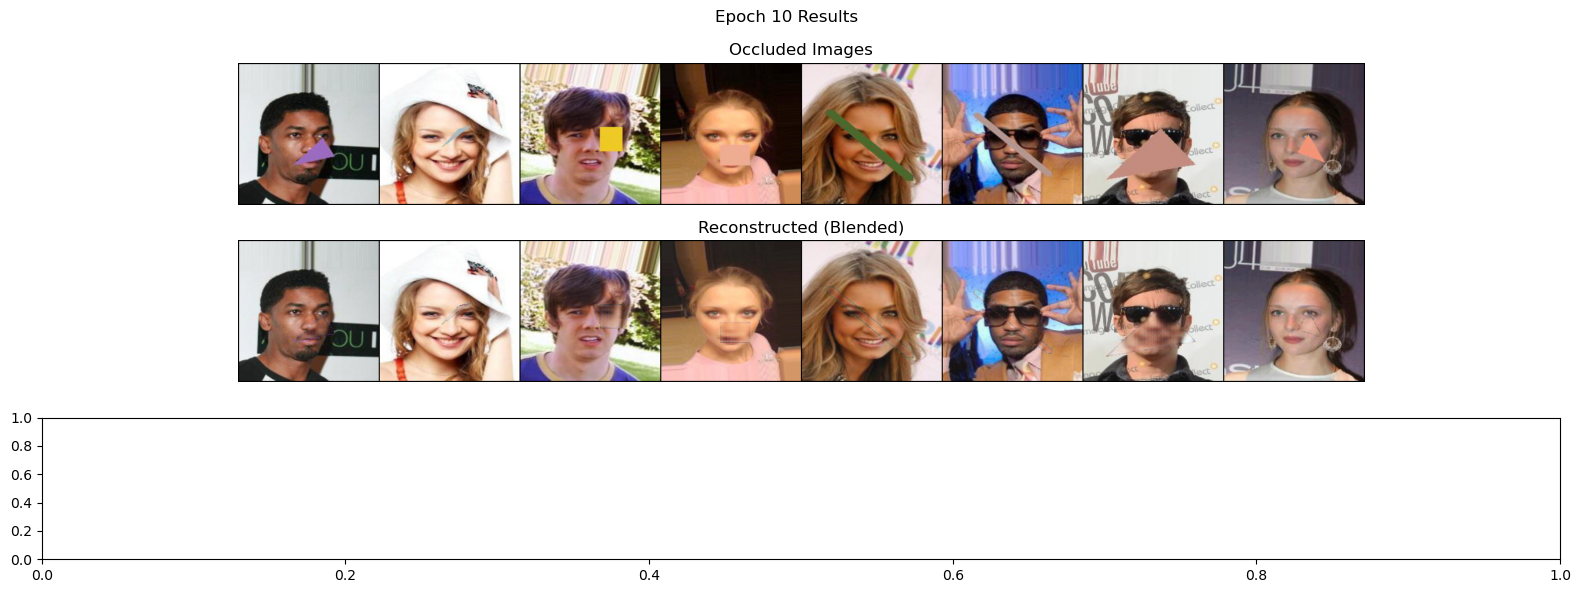

Epoch 10/50 -- G_loss: 2.1040, D_loss: 0.6503


Epoch 11/50 -- G_loss: 2.1190, D_loss: 0.6503


Epoch 12/50 -- G_loss: 2.1139, D_loss: 0.6504


Epoch 13/50 -- G_loss: 2.1114, D_loss: 0.6502


Epoch 14/50 -- G_loss: 2.1186, D_loss: 0.6504


Epoch 15/50 -- G_loss: 2.1051, D_loss: 0.6504


Epoch 16/50 -- G_loss: 2.1014, D_loss: 0.6509


Epoch 17/50 -- G_loss: 2.1018, D_loss: 0.6503


Epoch 18/50 -- G_loss: 2.1146, D_loss: 0.6506


Epoch 19/50 -- G_loss: 2.1063, D_loss: 0.6504


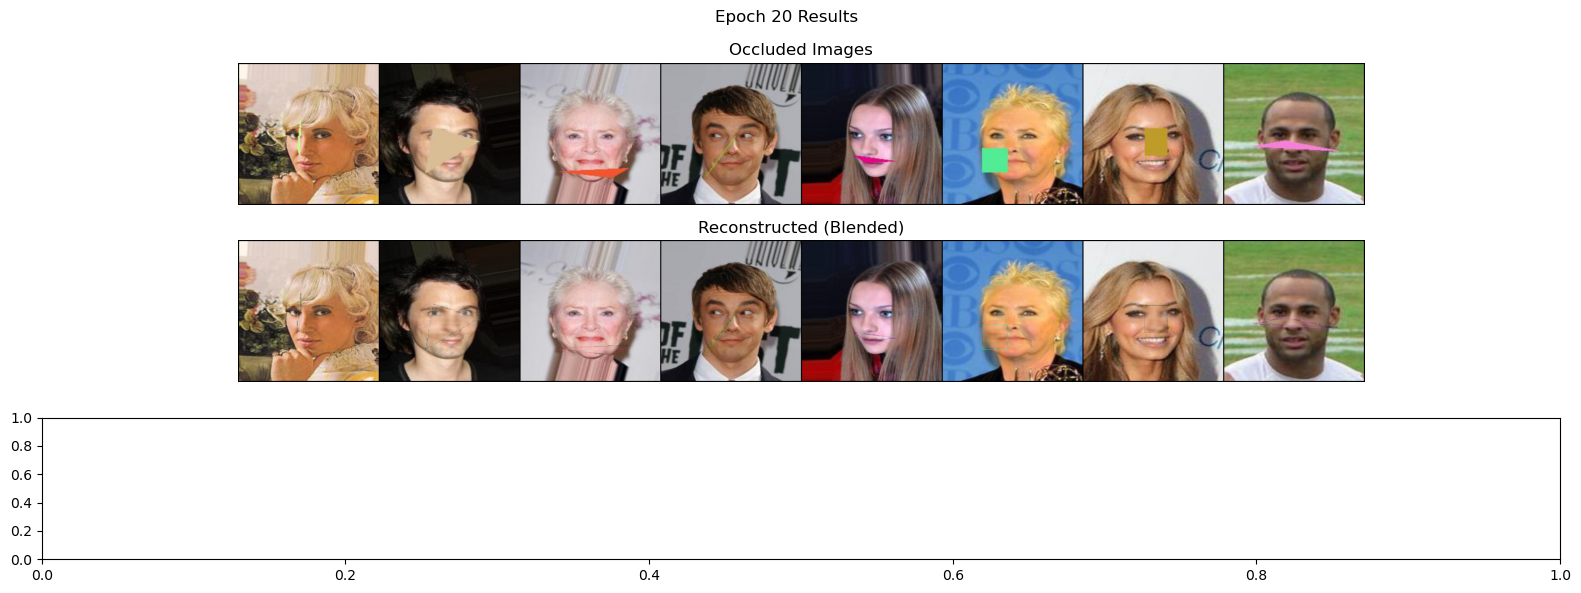

Epoch 20/50 -- G_loss: 2.1104, D_loss: 0.6503


Epoch 21/50 -- G_loss: 2.1106, D_loss: 0.6502


Epoch 22/50 -- G_loss: 2.1071, D_loss: 0.6511


Epoch 23/50 -- G_loss: 2.0979, D_loss: 0.6503


Epoch 24/50 -- G_loss: 2.1024, D_loss: 0.6503


Epoch 25/50 -- G_loss: 2.0980, D_loss: 0.6503


Epoch 26/50 -- G_loss: 2.1018, D_loss: 0.6502


Epoch 27/50 -- G_loss: 2.1035, D_loss: 0.6503


Epoch 28/50 -- G_loss: 2.1099, D_loss: 0.6503


Epoch 29/50 -- G_loss: 2.1157, D_loss: 0.6502


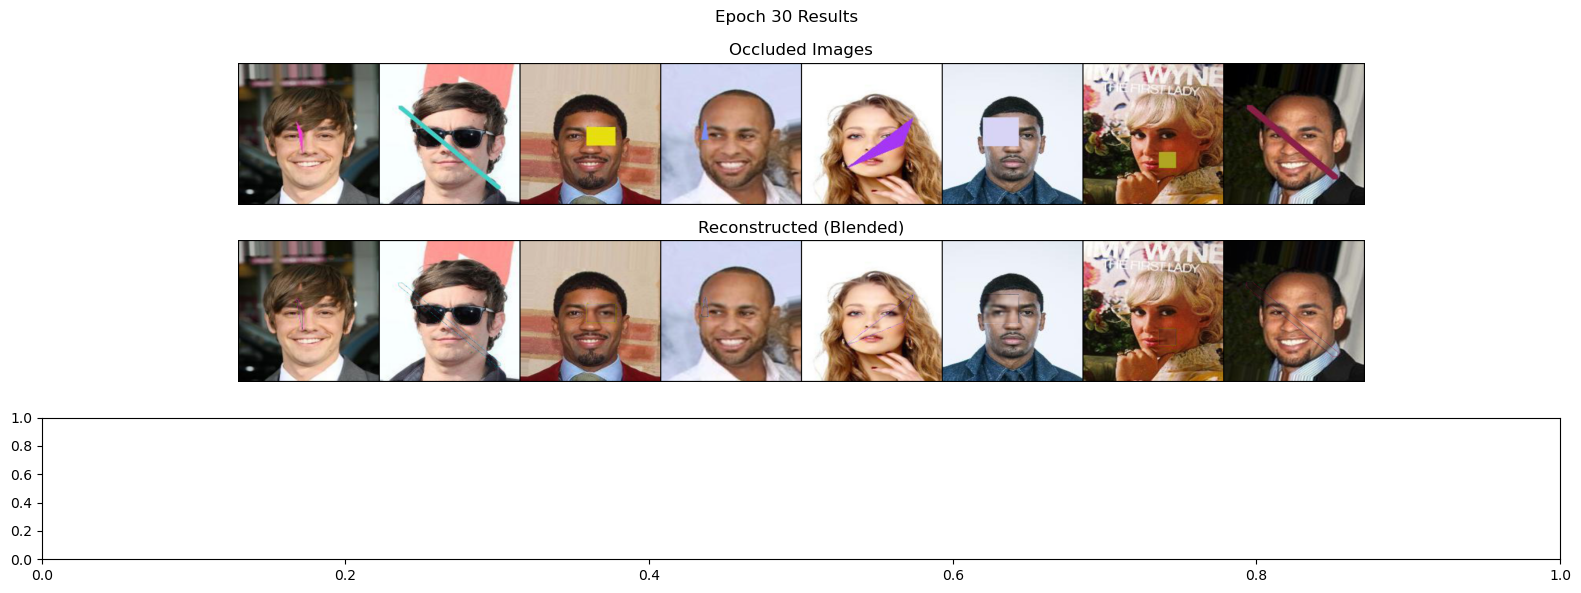

Epoch 30/50 -- G_loss: 2.1067, D_loss: 0.6503


Epoch 31/50 -- G_loss: 2.0948, D_loss: 0.6503


Epoch 32/50 -- G_loss: 2.1107, D_loss: 0.6503


Epoch 33/50 -- G_loss: 2.0985, D_loss: 0.6505


Epoch 34/50 -- G_loss: 2.1028, D_loss: 0.6502


Epoch 35/50 -- G_loss: 2.0990, D_loss: 0.6503


Epoch 36/50 -- G_loss: 2.0972, D_loss: 0.6502


Epoch 37/50 -- G_loss: 2.0957, D_loss: 0.6503


Epoch 38/50 -- G_loss: 2.0994, D_loss: 0.6504


Epoch 39/50 -- G_loss: 2.0998, D_loss: 0.6502


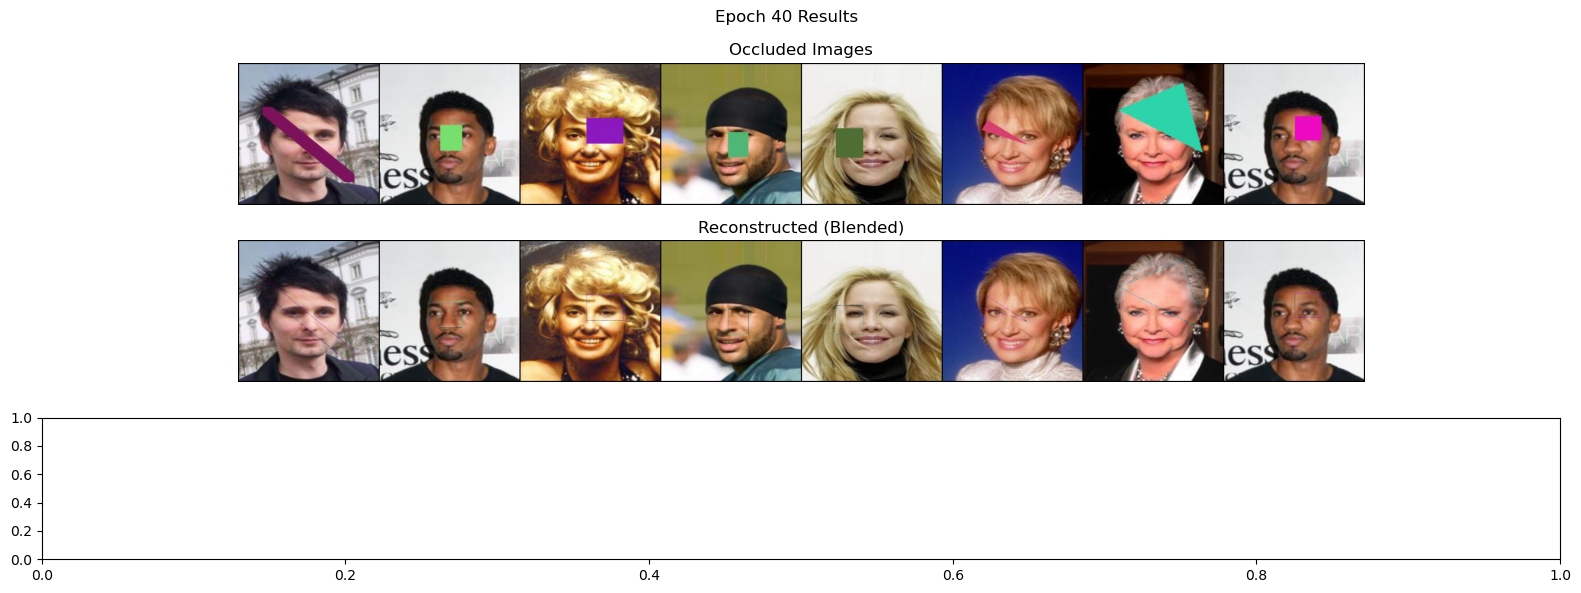

Epoch 40/50 -- G_loss: 2.0984, D_loss: 0.6502


Epoch 41/50 -- G_loss: 2.1030, D_loss: 0.6503


Epoch 42/50 -- G_loss: 2.0982, D_loss: 0.6502


Epoch 43/50 -- G_loss: 2.0958, D_loss: 0.6502


Epoch 44/50 -- G_loss: 2.0914, D_loss: 0.6502


Epoch 45/50 -- G_loss: 2.1135, D_loss: 0.6504


Epoch 46/50 -- G_loss: 2.1025, D_loss: 0.6502


Epoch 47/50 -- G_loss: 2.0918, D_loss: 0.6503


Epoch 48/50 -- G_loss: 2.1011, D_loss: 0.6502


Epoch 49/50 -- G_loss: 2.0976, D_loss: 0.6502


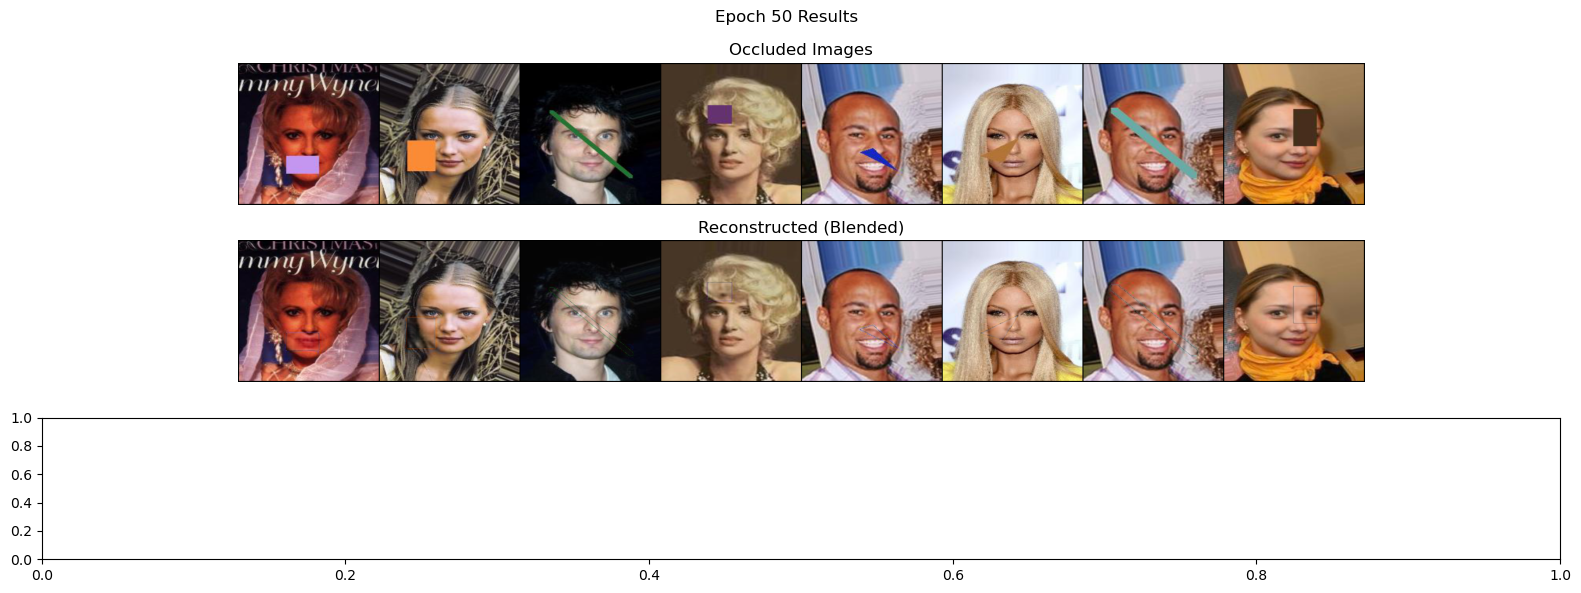

Epoch 50/50 -- G_loss: 2.0969, D_loss: 0.6502


In [24]:

# Simplified training loop with gradient clipping and error checking
from tqdm import tqdm
import numpy as np

def check_nan_loss(loss_value, name):
    if np.isnan(loss_value):
        print(f"WARNING: {name} is NaN!")
        return True
    return False

num_epochs = 50
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
   
    pbar = tqdm(loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
   
    for i, batch in enumerate(pbar):
        # Get data
        occluded = batch['occluded_image'].cuda(non_blocking=True)
        mask = batch['mask'].cuda(non_blocking=True)
        feature = batch['feature'].cuda(non_blocking=True)
       
        # Assume ground truth is provided or use occluded as a substitute
        gt = batch.get('imask', occluded).cuda(non_blocking=True)
       
        # Skip batch if any NaNs detected in input
        if torch.isnan(occluded).any() or torch.isnan(mask).any() or torch.isnan(feature).any():
            print("WARNING: NaN detected in input batch! Skipping...")
            continue
           
        # ======== Train Discriminator ========
        # Use try-except to catch errors
        try:
            with torch.no_grad():
                fake = generator(occluded, mask, feature)
               
            # Skip if NaNs in generator output
            if torch.isnan(fake).any():
                print("WARNING: NaN detected in generator output! Skipping batch...")
                continue
               
            real = gt
            fake_detach = fake.detach()
           
            # Add noise to labels for stability
            real_label = torch.ones_like(discriminator(real, mask)) * 0.9  # Label smoothing
            fake_label = torch.zeros_like(discriminator(fake_detach, mask)) + 0.1
           
            d_real = discriminator(real, mask)
            d_fake = discriminator(fake_detach, mask)
           
            # Calculate discriminator losses with error checking
            d_real_loss = bce(d_real, real_label)
            if check_nan_loss(d_real_loss.item(), "D_real_loss"):
                continue
               
            d_fake_loss = bce(d_fake, fake_label)
            if check_nan_loss(d_fake_loss.item(), "D_fake_loss"):
                continue
               
            d_loss = d_real_loss + d_fake_loss
           
            # Optimize discriminator with gradient clipping
            d_optimizer.zero_grad()
            d_loss.backward()
            nn.utils.clip_grad_norm_(discriminator.parameters(), max_grad_norm)
            d_optimizer.step()
           
        except RuntimeError as e:
            print(f"RuntimeError in discriminator training: {e}")
            continue
       
        # ======== Train Generator ========
        try:
            fake = generator(occluded, mask, feature)
           
            # Check for NaNs in generator output
            if torch.isnan(fake).any():
                print("WARNING: NaN detected in generator output! Skipping batch...")
                continue
               
            d_fake = discriminator(fake, mask)
           
            # Adversarial loss with label smoothing
            g_adv_loss = bce(d_fake, torch.ones_like(d_fake) * 0.9)
            if check_nan_loss(g_adv_loss.item(), "G_adv_loss"):
                continue
           
            # Reconstruction loss (masked region)
            g_l1_loss = l1(fake * mask, gt * mask)
            if check_nan_loss(g_l1_loss.item(), "G_l1_loss"):
                continue
               
            # Edge-aware loss with stability measures
            g_edge_loss = stable_edge_aware_loss(fake, gt, mask)
            if check_nan_loss(g_edge_loss.item(), "G_edge_loss"):
                continue
               
            # Combined loss with appropriate weights
            g_loss = g_adv_loss + 10 * g_l1_loss + g_edge_loss
           
            # Optimize generator with gradient clipping
            g_optimizer.zero_grad()
            g_loss.backward()
            nn.utils.clip_grad_norm_(generator.parameters(), max_grad_norm)
            g_optimizer.step()
           
        except RuntimeError as e:
            print(f"RuntimeError in generator training: {e}")
            continue
       
        # Update progress bar with safe values
        if not np.isnan(g_loss.item()) and not np.isnan(d_loss.item()):
            pbar.set_postfix({
                'G_loss': f"{g_loss.item():.4f}",
                'D_loss': f"{d_loss.item():.4f}"
            })
       
        # Periodically save model to prevent losing progress
        if i % 100 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
            }, f'checkpoint_latest.pth')
   
    # Visualization and epoch summary
    if (epoch + 1) % 10 == 0:
        try:
            test_batch = next(iter(loader))
            visualize_results(generator, test_batch, epoch)
           
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
            }, f'checkpoint_epoch_{epoch+1}.pth')
        except Exception as e:
            print(f"Error during visualization or checkpoint saving: {e}")
   
    print(f"Epoch {epoch+1}/{num_epochs} -- G_loss: {g_loss.item():.4f}, D_loss: {d_loss.item():.4f}")